In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Plots
;

In [3]:
const λ = 1
const Γ = 2π * 6.4e6
const m = 1
const k = 2π / λ
;

In [697]:
g1 = AngularMomentumState_Labelled(E=0, L=0, N=0, M=0)
g2 = AngularMomentumState_Labelled(E=40e6, L=0, N=0, M=0)
g3 = AngularMomentumState_Labelled(E=120e6, L=0, N=0, M=0)
e1 = AngularMomentumState_Labelled(E=478e12, L=1, N=0, M=0)
e2 = AngularMomentumState_Labelled(E=478e12+3e12, L=1, N=0, M=0)

ground_states = [g1, g2, g3]
excited_states = [e1, e2]
states = [ground_states; excited_states]

d_m = zeros(length(states), length(states))
d_m[3,4] = d_m[4,3] = 1.0 # g3 -> e1

d_0 = zeros(length(states), length(states))
d_0[1,4] = d_0[4,1] = 1.0 # g1 -> e1

d_p = zeros(length(states), length(states))
d_p[2,5] = d_p[5,2] = 1.0 # g2 -> e2

d = zeros(length(states), length(states), 3)
d[:,:,1] = d_m
d[:,:,2] = d_0
d[:,:,3] = d_p

d ./= sum(d[:,:,1].^2)
d ./= sum(d[:,:,2].^2)
d ./= sum(d[:,:,3].^2)
;

In [698]:
# Laser parameters
s1 = 4e8
Δ1 = -200e12

s2 = 4e8
Δ2 = -200e12

s3 = 100.
Δ3 = 0.

# Frequency of the lasers (in angular frequency units)
ω1 = 2π * (e1.E - g1.E + Δ1)
ω2 = 2π * (e1.E - g1.E + Δ2)
ω3 = 2π * (g3.E - e1.E + Δ3)

ϵ_(ϵ) = t -> ϵ
s_func(s) = (r,t) -> s

pol1 = σ⁰
pol2 = σ⁺
pol3 = σ⁻

k̂ = +ẑ; ϵ1 = ϵ_(pol1); laser1 = Field(k̂, ϵ1, ω1, s_func(s1))
k̂ = +ẑ; ϵ2 = ϵ_(pol2); laser2 = Field(k̂, ϵ2, ω2, s_func(s2))
k̂ = +ẑ; ϵ3 = ϵ_(pol3); laser3 = Field(k̂, ϵ3, ω3, s_func(s3))

lasers = [laser1, laser2, laser3]
;

In [699]:
ψ₀ = zeros(ComplexF64, length(states))
ψ₀[1] = +1/√2
ψ₀[2] = +1/√2
# ψ0[3] = +1/√2
# ψ0[4] = -1/√2
;

In [700]:
H₀ = zeros(ComplexF64, length(states), length(states))
# H₀[1,1] = g1.E
# H₀[2,2] = g2.E
# H₀[3,3] = e1.E
# H₀[4,4] = e2.E
;

In [707]:
# `Particle` type defines the starting position `r0` and velocity `v` used for the simulation
particle = Particle()

p = schrödinger(particle, states, H₀, lasers, d, nothing, ψ₀, false; Γ=Γ)

# Define the time span
tspan = (0., 0.04) #./ (1/Γ)

prob = ODEProblem(ψ!, ψ₀, tspan, p)
;

In [725]:
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-4, maxiters=1e8)
;

  0.668838 seconds (1.89 M allocations: 257.096 MiB)


In [726]:
# @time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-6, abstol=1e-7, saveat=0.1, maxiters=1e8)
# ;

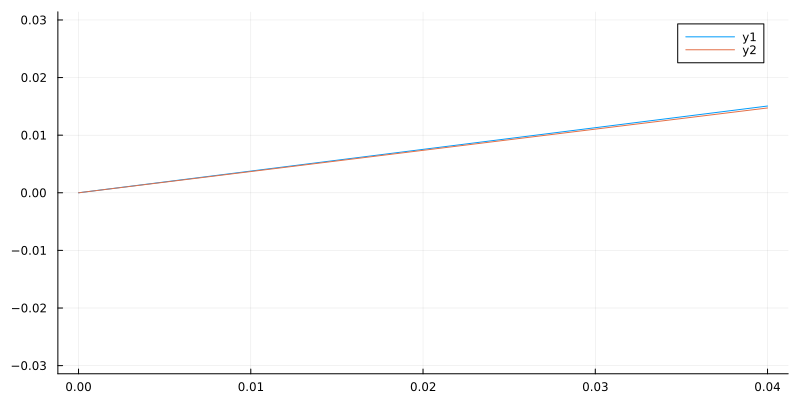

In [727]:
using Plots
plot_ts = sol.t[1:10:end]
plot_us = sol.u[1:10:end]

plot(size=(800, 400), ylim=(-0.01π, 0.01π))

plot!(plot_ts, [angle(u[1]) for u in plot_us])
plot!(plot_ts, [angle(u[2]) for u in plot_us])

plot!()

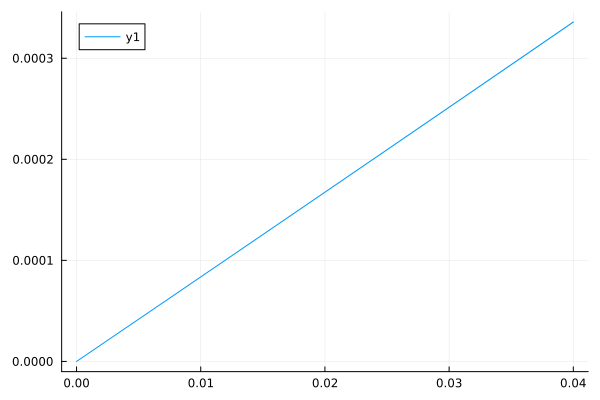

In [728]:
plot(plot_ts, [angle(u[1])-angle(u[2]) for u in plot_us])

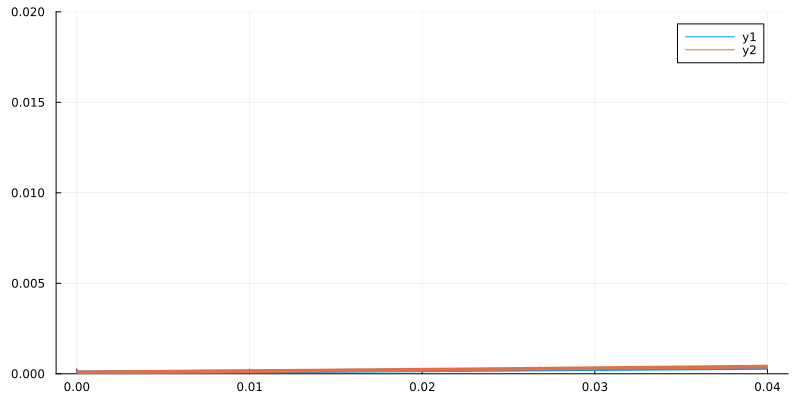

In [729]:
using Plots

plot(size=(800, 400), ylim=(0, 0.02))

plot!(plot_ts, [norm(u[4]) for u in plot_us])
plot!(plot_ts, [norm(u[5]) for u in plot_us])

plot!()